# Buckshot++: A Scalable, Noise-Tolerant Bagging approach to the Buckshot Algorithm

Despite the k-means algorithm being one of the most important unsupervised learning methods today, the Achilles' heel of this algorithm is the need to determine beforehand the number of clusters. A common approach is: take some metric, evaluate at multiple values of K, and let some greedy search determine when to stop (typically elbow heuristic). This notebook shows a better way. I will introduce 3 improvements:   
1. I show that some metrics are powerful, while others are too inconsistent to be useful
2. A big problem with k-means is that every single point is clustered--but what we really want is the pattern and not the noise. I show a beautiful way to solve this problem--and much simpler than k-medoids and k-medians to boot. 
3. Running k-means multiple times to find the best K is expensive in computation time, and just doesn't scale. I show a surprisingly simple alternative that *does* scale. 

In [ ]:
'''A Scalable, Noise-Tolerant Bagging approach to the Buckshot Algorithm.
Reference to the original buckshot algorithm (https://pdfs.semanticscholar.org/1134/3448f8a817fa391e3a7897a95f975ad2873a.pdf)'''

In [1]:
from numpy.random import choice
from pandas import read_csv, DataFrame
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_mutual_info_score
import matplotlib.pyplot as plt
from functools import reduce
import os, sys
sys.path.insert(0, 'C:/Users/jjung/Documents/GitHub/News-Spam-Detect/TxtClus/')
# sys.path.insert(0, '/home/jz/proj/News-Spam-Detect/TxtClus')
from baggedBuckshot import Clusterings

In [2]:
def plot_mult_samples(listOf_df, row_name):     
    '''For each bootstrap iteration, plot metrics across K''' 
    for i in range(len(listOf_df)):
        plt.plot(list(listOf_df[i].columns), list(listOf_df[i].loc[row_name,:]), c="green")  
    
    # Use the reduce function to do elementwise average for several data frames:
    avg_metrics = reduce(lambda df1, df2: df1.add(df2), listOf_df).div(len(listOf_df))        
    plt.plot(list(avg_metrics.columns), list(avg_metrics.loc[row_name,:]), c="red")    
    plt.ylabel(row_name + ' score')   
    plt.xlabel('no. of clusters')        
    plt.show()            

## Background
The novel algorithm that I will explain here (hereinafter I will call Buckshot++) is motivated by the paper [Pedersen et al.](https://pdfs.semanticscholar.org/1134/3448f8a817fa391e3a7897a95f975ad2873a.pdf) The essence of the Buckshot algorithm outline in that paper is to find cluster centers by performing hierarchical clustering on a sample and then perform k-means by inputting those cluster centers. Table 1 below explains why the Buckshot algorithm takes this approach:

In [11]:
print('Table 1')
tbl = DataFrame({'k-means': ['O(N * k * d * i)', 'random initial means; local minimum; outliers'],
                 'hierarchical': ['O(N^2 * logN)', 'outliers']}
                , index=['Computational Complexity', 'Sources of Instability'])
tbl

Table 1


,hierarchical,k-means
Computational Complexity,O(N^2 * logN),O(N * k * d * i)
Sources of Instability,outliers,random initial means; local minimum; outliers


The shockingly high time complexity of hierarchical is why the Buckshot algorithm performs hierarchical only on a sample. Let's look at what Buckshot++ is and how it simultaneously tackles scalability and stability issues.  

## The Buckshot++ Algorithm

1. Take B bootstrap samples where each sample is of size 1/F.  
2. For each K from 2 to F do:  
        2a. Pass parameter K into kmeans computation.  
        2b. Compute the metric M.
3. Compute the centroid of all metrics vectors.  
4. Output: argmax of the centroid vector.        

## Implementation & Empirical Discoveries
Having given the background and the concept of Buckshot++, the following sections are a walkthrough of the way I implemented the algorithm. In the cell below, I import the [Kaggle News Aggregator Dataset](https://www.kaggle.com/uciml/news-aggregator-dataset) that I will use to illustrate my algorithm. In this data, there's a field that contains news headlines and another field that holds an ID indicating which story a headline belongs to. 

In [3]:
if __name__ == "__main__":
    # Pass in settings to instantiate a Clusterings object called vecSpaceMod1:
    vecSpaceMod = Clusterings({'file_loc': sys.path[0] + '/Input/newsSample.csv',
                               'tf_dampen': True,
                               'common_word_pct': 1,
                               'rare_word_pct': 1,
                               'dim_redu': False})
    news_df = vecSpaceMod.get_file() # Read CSV input to data frame.

In [4]:
    # Repeatedly run kmeans on resamples, compute the silhouette and calinski metrics for each K that I plug in.  
    metrics_byK = vecSpaceMod.buckshot(news_df)        

## Bagging *does* make sense here!
Each green curve is generated from a bootstrap sample, and the red curve is their average. Remember the sources of instability for k-means listed in Table 1. Within that list, the concept of outlier has a somewhat different meaning in the context of clustering. In supervised learning, an outlier is a rare observation that happens to be far from other observations. In clustering, a far away observation is its own well-separated cluster. So my interpretation is that "rare" is the operative word here and that outliers are singleton clusters that exert undue influence on the formation of other clusters. Look at how [bagging](https://en.wikipedia.org/wiki/Bootstrap_aggregating) imparted a more stable estimate of the relationship between the number of clusters and the silhouette score in the graph below.

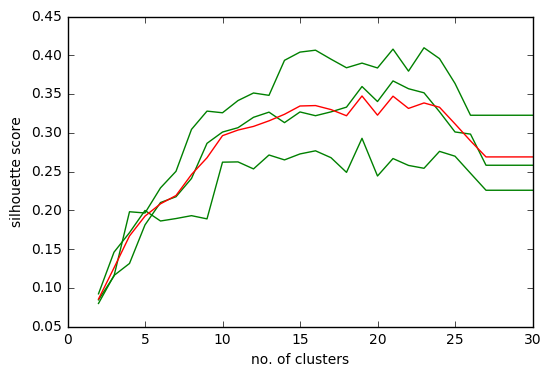

In [5]:
    plot_mult_samples(metrics_byK, 'silhouette')

## Useful and not-so-useful internal clustering metrics currently out there.
The two internal clustering metrics implemented in scikit-learn are: the Silhouette Coefficient and the Calinski-Harabasz criterion. Comparing the Silhouette plotted above with the Calinski plotted below, it's clear that Silhouette is clearly better.

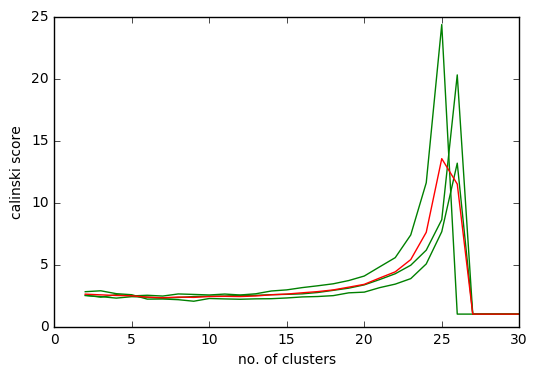

In [6]:
    plot_mult_samples(metrics_byK, 'calinski')

In [12]:
    X = vecSpaceMod.term_weight_matr(news_df.TITLE)
    kmeans_fit = KMeans(21).fit(X)

## Are the quality of the clusters good?
Taking a look at the documents and their corresponding "predictedCluster", the results certainly do impress!

In [13]:
    cluster_results = DataFrame({'predictedCluster': kmeans_fit.labels_,
                                 'document': news_df.TITLE})
    cluster_results.sort_values(by='predictedCluster', inplace=True)
    cluster_results

,document,predictedCluster
48,Microsoft wants Windows XP dead and has announ...,0
50,Zebra Technologies to Acquire Enterprise Busin...,0
25,SAC Capital Starts Anew as Point72,0
23,Fine Tuning: Good Wife just gets better,0
80,Nutrition in Crops Are Cut down Drastically by...,0
73,Electricity out as Millstone shifts to diesel,0
74,McAuliffe puts focus on women's health,0
46,'Mad Men': Season 7 Premiere Guide (Video),1
37,TV Review: Mad Men Season 7,1
53,'Mad Men' Season 7 Spoilers: Everything We Kno...,1


## Internal or External Clustering Metrics?
With the ground truth labels, we can evaluate Mutual Information, which is the most commonly used external metric. Looking at 0.63 Mutual Information compared with about 0.35 Silhouette, the relationship between the metrics is fairly consistent with other studies.

In [15]:
    mutual_info = adjusted_mutual_info_score(labels_true=news_df.STORY, labels_pred=kmeans_fit.labels_) 
    print(mutual_info)

0.638939858796


## Buckshot++ Scales Better Than Buckshot.
The fact is that hierarchical clustering has a much higher order of time complexity than k-means. This means that, for sizable inputs, running k-means multiple times is still faster than running hierarchical clustering just once. The Buckshot algorithm runs hierarchical just once on a small sample in order to initialize cluster centers for k-means. Since O(N^2 * logN) grows really fast, the sample must be really small to make it work computationally. But the chief critique of Buckshot is 